# Noise2Void - 3D Example

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
import random

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

2024-09-05 01:06:16.614839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-05 01:06:16.614870: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Training Data Preparation
For training we will load __one__ low-SNR 3D-tif-volume and use the <code>N2V_DataGenerator</code> to extract non-overlapping 3D-patches. Since N2V is a self-supervised method, we don't need targets.

In [2]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [3]:
# We will load all the '.tif' files from the 'data' directory. In our case it is only one.
# The function will return a list of images (numpy arrays).
# In the 'dims' parameter we specify the order of dimensions in the image files we are reading.
imgs = []
imgs.extend(datagen.load_imgs_from_directory(
    directory="data/standard",
    dims='TZYX',
))
# Let's look at the shape of the image
print(imgs[0].shape)
# The function automatically added two extra dimension to the images:
# One at the front is used to hold a potential stack of images such as a movie.
# One at the end could hold color channels such as RGB.

(73, 10, 512, 512, 1)


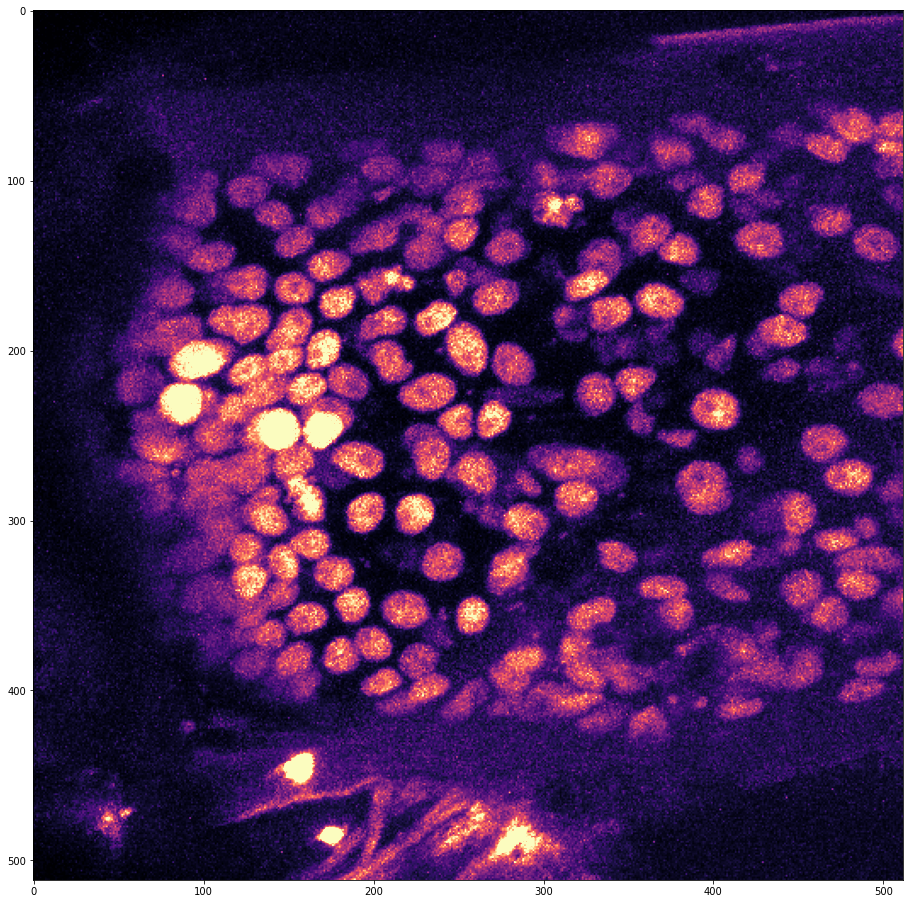

In [4]:
# Let's look at a maximum projection of the volume.
# We have to remove the added extra dimensions to display it.
plt.figure(figsize=(32,16))
plt.imshow(np.max(imgs[0][0,...,0],axis=0), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()

In [5]:
# Here we extract patches for training and validation.
patch_shape = (8, 64, 64)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)

Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 8, 64, 64, 1)
Generated patches: (512, 

In [6]:
len(patches)

37376

In [7]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
X = patches[:int(len(patches) * 0.7)]
X_val = patches[int(len(patches) * 0.7):]
print(f'training data: {len(X)}')
print(f'validation data: {len(X_val)}')

training data: 26163
validation data: 11213


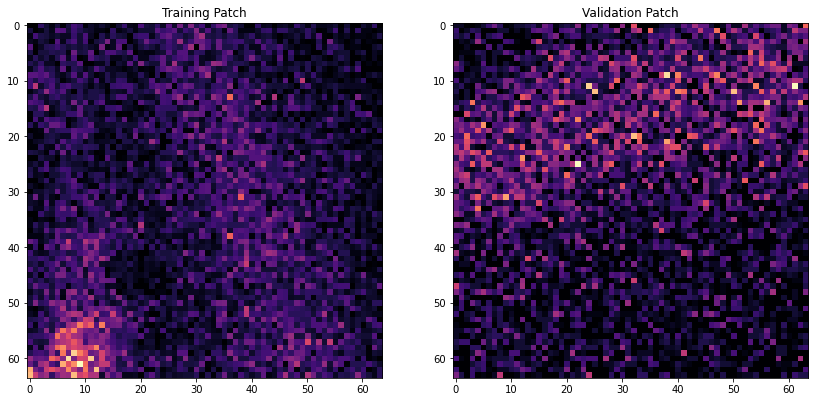

In [8]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,4,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,4,...,0],cmap='magma')
plt.title('Validation Patch');

## Configure
Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64), but since this is an 3D example we obviously need to specify a triple, here (32, 64, 64).  

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the `single_net_per_channel` option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough. <br/>
__Note:__ Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 20. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [9]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128),train_epochs=200, train_loss='mse', batch_norm=True, 
                   train_batch_size=4, n2v_perc_pix=0.198, n2v_patch_shape=(8, 64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['7.028621'],
 'stds': ['12.921288'],
 'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 200,
 'train_steps_per_epoch': 204,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (8, 64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [10]:
# a name used to identify the model
model_name = 'n2v_3D_movie1-16'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)

/lustre1/users/sugawara/micromamba/envs/n2v/lib/python3.7/site-packages/n2v/models/n2v_standard.py:430: UserWarning: output path for model already exists, files may be overwritten: /lustre1/users/sugawara/Repositories/n2v/examples/3D/models/n2v_3D_movie1-16
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
2024-09-05 01:06:50.928318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-05 01:06:50.928370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-09-05 01:06:50.928407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open s

## Training

In [11]:
history = model.train(X, X_val)

64 blind-spots will be generated per training patch of size (8, 64, 64).


Preparing validation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 11213/11213 [00:01<00:00, 6400.16it/s]


Epoch 1/50


2024-04-02 02:10:21.584123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-04-02 02:10:23.327418: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1625d0eb60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-02 02:10:23.327448: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-02 02:10:23.327453: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-02 02:10:23.331832: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-02 02:10:23.512304: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


204/204 [==============================] - 37s 126ms/step - loss: 0.4992 - n2v_mse: 0.4992 - n2v_abs: 0.4186 - val_loss: 0.2610 - val_n2v_mse: 0.2608 - val_n2v_abs: 0.3245 - lr: 4.0000e-04
Epoch 2/50
204/204 [==============================] - 15s 76ms/step - loss: 0.3464 - n2v_mse: 0.3464 - n2v_abs: 0.3633 - val_loss: 0.2171 - val_n2v_mse: 0.2169 - val_n2v_abs: 0.2681 - lr: 4.0000e-04
Epoch 3/50
204/204 [==============================] - 16s 77ms/step - loss: 0.4008 - n2v_mse: 0.4008 - n2v_abs: 0.3663 - val_loss: 0.2093 - val_n2v_mse: 0.2092 - val_n2v_abs: 0.2528 - lr: 4.0000e-04
Epoch 4/50
204/204 [==============================] - 16s 77ms/step - loss: 0.3853 - n2v_mse: 0.3853 - n2v_abs: 0.3651 - val_loss: 0.1400 - val_n2v_mse: 0.1401 - val_n2v_abs: 0.2385 - lr: 4.0000e-04
Epoch 5/50
204/204 [==============================] - 15s 76ms/step - loss: 0.2858 - n2v_mse: 0.2858 - n2v_abs: 0.3299 - val_loss: 0.1407 - val_n2v_mse: 0.1406 - val_n2v_abs: 0.2331 - lr: 4.0000e-04
Epoch 6/50
204/

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


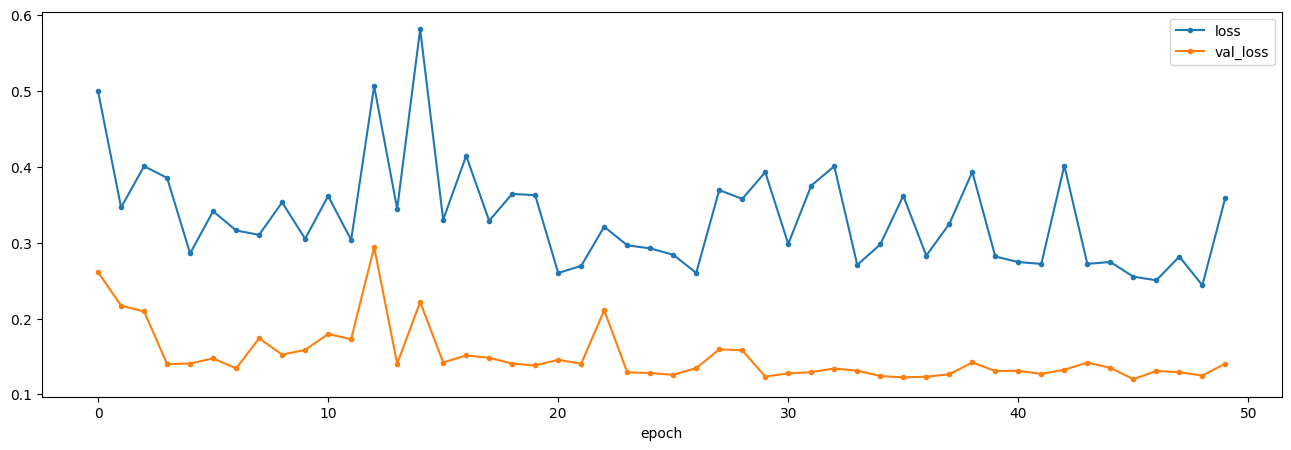

In [12]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model in BioImage ModelZoo Format
See https://imagej.net/N2V#Prediction for details.

In [13]:
model.export_TF(name='Noise2Void - 3D Parhyale', 
                description='This is the 3D Noise2Void model for Parhyale confocal data movie1-16.', 
                authors=["Ko Sugawara"],
                test_img=X_val[0,...,0], axes='ZYX',
                patch_shape=patch_shape)

1/1 [==============================] - 0s 312ms/step
INFO:tensorflow:Assets written to: /mnt/md0/projects/05_DeepLineage/subsampling_evaluation/n2v/models/n2v_3D_movie1-16/tf_model/assets


INFO:tensorflow:Assets written to: /mnt/md0/projects/05_DeepLineage/subsampling_evaluation/n2v/models/n2v_3D_movie1-16/tf_model/assets
site.config.json: 6.68kiB [00:00, 4.51MiB/s]                                                                                                                                      
/mnt/md0/applications/mamba_root/envs/n2v/lib/python3.9/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (6678) does not have expected size (2331).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
collection.json: 235kiB [00:00, 26.7MiB/s]                                                                                                                                        
/mnt/md0/applications/mamba_root/envs/n2v/lib/python3.9/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (234743) does not have expected size (28502).
  warnings.warn(f"Download ({t.n}) does not have expected s

AssertionError: 

In [13]:
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible
from pathlib import Path

In [14]:
model = N2V(config=config, name=model_name, basedir=basedir)

/mnt/md0/applications/mamba_root/envs/n2v/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /mnt/md0/projects/05_DeepLineage/subsampling_evaluation/n2v/models/n2v_3D_movie1-16_50epochs
  warnings.warn(


In [15]:
datadir = 'data/standard'
preddir = datadir + '_n2v_200epoch'
Path(preddir).mkdir(exist_ok=True)
img = imread(f'{datadir}/standard.tif')
preds = []
for t in range(img.shape[0]):
    pred = model.predict(img[t], axes='ZYX', n_tiles=(2,4,4))
    pred -= pred.min()
    pred = (pred / pred.max() * 255).astype(np.uint8)
    preds.append(pred)
result = np.array(preds)
save_tiff_imagej_compatible(f'{preddir}/standard_n2v_200epoch.tif', result, 'TZYX')

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 2s 2s/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 41943.04it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.67it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.67it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.04it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.04it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.85it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.52it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.26it/s]

1/1 [==============================] - 0s 39ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.89it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.93it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.94it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.32it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 40ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 40329.85it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.78it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.78it/s]

1/1 [==============================] - 0s 39ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.17it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.17it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.82it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.82it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.57it/s]

1/1 [==============================] - 0s 39ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.30it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.19it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.00it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.87it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.33it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 47662.55it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.34it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.34it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.40it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.40it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.09it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.09it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.15it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.93it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.41it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 37ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 39199.10it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.19it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.19it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.00it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:01, 11.00it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.47it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.16it/s]

1/1 [==============================] - 0s 35ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.07it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.03it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.42it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 37ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 32513.98it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.94it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.94it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.46it/s]

1/1 [==============================] - 0s 33ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.46it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.34it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.92it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.36it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.12it/s]

1/1 [==============================] - 0s 39ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.93it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.52it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 37ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 41943.04it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.52it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.52it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 10.90it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:01, 10.90it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.48it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.14it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.07it/s]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.02it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.82it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.85it/s]

1/1 [==============================] - 0s 38ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.81it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.24it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 39199.10it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.44it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.44it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.36it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.36it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.55it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.01it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.01it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.74it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.34it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 46091.25it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.08it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.08it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.43it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.43it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.57it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.27it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.07it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.49it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 38836.15it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.47it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.47it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.66it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.66it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.23it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.73it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.28it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.17it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.28it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.56it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 44620.26it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.15it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.15it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.35it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.35it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.42it/s]

1/1 [==============================] - 0s 34ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.35it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.52it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 22075.28it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.60it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.60it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.20it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.20it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.65it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.65it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.30it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.21it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.15it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.95it/s]

1/1 [==============================] - 0s 35ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.97it/s]

1/1 [==============================] - 0s 34ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.43it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 37ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 51150.05it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.29it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.29it/s]

1/1 [==============================] - 0s 39ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.35it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.35it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.95it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.40it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 37786.52it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.30it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.30it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.36it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.36it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.03it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.03it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.44it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.23it/s]

1/1 [==============================] - 0s 40ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.07it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.03it/s]

1/1 [==============================] - 0s 35ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 34ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.25it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.46it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 39945.75it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.79it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.79it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.42it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.42it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.32it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.32it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.77it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.36it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.35it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.15it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.14it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.54it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 42366.71it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.41it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.41it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.25it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.25it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.93it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.93it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.03it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.40it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 43690.67it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.98it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.98it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.09it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.09it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.25it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.03it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.97it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.96it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.42it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 46091.25it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.14it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.14it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.44it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.44it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.52it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.93it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.44it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 43690.67it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.30it/s]

1/1 [==============================] - 0s 38ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.30it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.31it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.31it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.09it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.66it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.66it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.25it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.87it/s]

1/1 [==============================] - 0s 35ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.98it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.42it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 34379.54it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.19it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.19it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.37it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.37it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.58it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.07it/s]

1/1 [==============================] - 0s 33ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  5.96it/s]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  6.36it/s]

1/1 [==============================] - 0s 39ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  6.75it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  7.59it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.94it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 40ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 46091.25it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.47it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.47it/s]

1/1 [==============================] - 0s 40ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 10.95it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:01, 10.95it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.47it/s]

1/1 [==============================] - 0s 34ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.29it/s]

1/1 [==============================] - 0s 38ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.92it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.99it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.97it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.35it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 34ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 43690.67it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.54it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.54it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.34it/s]

1/1 [==============================] - 0s 33ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.34it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.05it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.05it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.61it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.61it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.36it/s]

1/1 [==============================] - 0s 33ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.19it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.53it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 39945.75it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.03it/s]

1/1 [==============================] - 0s 33ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.03it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.51it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.51it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.00it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.00it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.21it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.17it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.04it/s]

1/1 [==============================] - 0s 33ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.96it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.42it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 49344.75it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.94it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.94it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.73it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.73it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.21it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.29it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.17it/s]

1/1 [==============================] - 0s 33ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.51it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 38ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 48210.39it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.35it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.35it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.34it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.34it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.06it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.25it/s]

1/1 [==============================] - 0s 38ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.03it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.01it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.85it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.37it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 41120.63it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.08it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.08it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.51it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.51it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.01it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.01it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.72it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.72it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.43it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.15it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.17it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.49it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 40329.85it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.44it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.44it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.19it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.19it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.93it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.93it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.21it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.08it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.51it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 51150.05it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.37it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.37it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.41it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.41it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.63it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.63it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.28it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.25it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.94it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.44it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 41120.63it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.91it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.91it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.54it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.54it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.11it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.30it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.25it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.01it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.45it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 44150.57it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.24it/s]

1/1 [==============================] - 0s 38ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.24it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.24it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.24it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.11it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.11it/s]

1/1 [==============================] - 0s 40ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.22it/s]

1/1 [==============================] - 0s 38ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.07it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.93it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.96it/s]

1/1 [==============================] - 0s 38ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.89it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.34it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 46091.25it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.11it/s]

1/1 [==============================] - 0s 38ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.11it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.29it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.29it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.12it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.03it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.44it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 43690.67it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.10it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.10it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.14it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.14it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.72it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.72it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.44it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.04it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.53it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 46091.25it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.29it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.29it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.87it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.87it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.75it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.43it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.36it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.52it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 46091.25it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.34it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.34it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.48it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.48it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.06it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.29it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.03it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.07it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.43it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 40721.40it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.51it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.51it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.62it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.62it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.78it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.78it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.04it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.93it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.45it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 42799.02it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.51it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.51it/s]

1/1 [==============================] - 0s 39ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:01, 10.93it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.69it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.69it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.19it/s]

1/1 [==============================] - 0s 35ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.01it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.98it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.03it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.32it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 41943.04it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.23it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.23it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.18it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.18it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.07it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.51it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.16it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.96it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.94it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.40it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 43240.25it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.09it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.09it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.42it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.42it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.05it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.65it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.65it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.38it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.22it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.98it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.57it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 47127.01it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.18it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.18it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.31it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.31it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.09it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.55it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.39it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.53it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 39945.75it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.45it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.45it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.54it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.54it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.30it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.20it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.08it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.58it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 38ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 40329.85it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.43it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.43it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.11it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.11it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.64it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.40it/s]

1/1 [==============================] - 0s 39ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.95it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.96it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.35it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 48770.98it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.78it/s]

1/1 [==============================] - 0s 38ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.78it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.01it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.01it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.84it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.84it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.28it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.40it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 46091.25it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.84it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.84it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.39it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.39it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.96it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.96it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.63it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.46it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.04it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.47it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 37ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 33554.43it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.50it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.50it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.63it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.63it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.49it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.32it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.30it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.54it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 39199.10it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.82it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.82it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.74it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.74it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.74it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.37it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.57it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 47662.55it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.52it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.52it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.51it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.51it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.81it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.47it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.14it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.54it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 39945.75it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.32it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.32it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.53it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.53it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.21it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.21it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.49it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.42it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.56it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 42799.02it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.40it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.40it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.60it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.60it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.11it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.11it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.73it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.37it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.34it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.07it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.47it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 28926.23it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.26it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.26it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.29it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.29it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.04it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.57it/s]

1/1 [==============================] - 0s 34ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.27it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.27it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.49it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 48770.98it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.10it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.10it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.34it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.34it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.64it/s]

1/1 [==============================] - 0s 34ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.48it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.14it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.53it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 37ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 39945.75it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.06it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.06it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.12it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.12it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.91it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.66it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.66it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.47it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.39it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.36it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.66it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 49344.75it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.96it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.96it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.35it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.35it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.08it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.81it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.32it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.01it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.99it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.50it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 40721.40it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.85it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.85it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.87it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.87it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.20it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.24it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.13it/s]

1/1 [==============================] - 0s 35ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.23it/s]

1/1 [==============================] - 0s 38ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.07it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.48it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 47127.01it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.20it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.20it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.43it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.43it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.12it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.61it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.61it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.21it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.17it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.51it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 38ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 44620.26it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.73it/s]

1/1 [==============================] - 0s 33ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.73it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.56it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.56it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.42it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 39199.10it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.08it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.08it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.20it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.20it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.76it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.50it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.21it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.91it/s]

1/1 [==============================] - 0s 35ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.04it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.34it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 48770.98it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.82it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.82it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.24it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.24it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.80it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.80it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.23it/s]

1/1 [==============================] - 0s 35ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.20it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.19it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.01it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.04it/s]

1/1 [==============================] - 0s 38ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.87it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.34it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 45590.26it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.07it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.07it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.52it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.52it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.22it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.68it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.36it/s]

1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.12it/s]

1/1 [==============================] - 0s 34ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.35it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.60it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 38130.04it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.36it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.36it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.19it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.19it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.77it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.43it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.28it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.15it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.49it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 41943.04it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.75it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.75it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.20it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.20it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.00it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.78it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.78it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.46it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.32it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.13it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.49it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 45590.26it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.51it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.51it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.39it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.39it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.08it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.77it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.77it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.47it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.15it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.00it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.99it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.48it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 42799.02it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.94it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.94it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.72it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.72it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.30it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.30it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.61it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.61it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.39it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.12it/s]

1/1 [==============================] - 0s 38ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.04it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.50it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 48210.39it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.29it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.29it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.46it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.46it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.14it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.72it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.72it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:00<00:00,  9.49it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.13it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.53it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 37ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 46091.25it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 16.94it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 16.94it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.14it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.14it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.88it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.88it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.34it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.07it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.03it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.00it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.42it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 37ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 49344.75it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.26it/s]

1/1 [==============================] - 0s 38ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.26it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.18it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.18it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.65it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.65it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.39it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.21it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.99it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.99it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.00it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.47it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 45100.04it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.99it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.99it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.40it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.40it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.92it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.53it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.49it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.26it/s]

1/1 [==============================] - 0s 38ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.05it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.93it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.42it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 37ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 33288.13it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.81it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.81it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.41it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.41it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.13it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.59it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.59it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.37it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.25it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.19it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.52it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 35ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 48210.39it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.06it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.06it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.37it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.37it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.55it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.22it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.02it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.98it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.40it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 41943.04it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.35it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.35it/s]

1/1 [==============================] - 0s 33ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.22it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.22it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.08it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.81it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.81it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.11it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.99it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.95it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.01it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.45it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 36ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 41527.76it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 18.18it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 18.18it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.83it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.83it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  5.91it/s]

1/1 [==============================] - 0s 42ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:01,  6.41it/s]

1/1 [==============================] - 0s 40ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:01<00:01,  6.86it/s]

1/1 [==============================] - 0s 40ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:01<00:00,  7.26it/s]

1/1 [==============================] - 0s 40ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  7.62it/s]

1/1 [==============================] - 0s 41ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  7.84it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  8.05it/s]

1/1 [==============================] - 0s 40ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.18it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.22it/s]

1/1 [==============================] - 0s 40ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.30it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.85it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 41ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 44150.57it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.34it/s]

1/1 [==============================] - 0s 40ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.34it/s]

1/1 [==============================] - 0s 39ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.17it/s]

1/1 [==============================] - 0s 39ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.17it/s]

1/1 [==============================] - 0s 45ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.58it/s]

1/1 [==============================] - 0s 41ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.58it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.21it/s]

1/1 [==============================] - 0s 39ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.06it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.08it/s]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.02it/s]

1/1 [==============================] - 0s 39ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.88it/s]

1/1 [==============================] - 0s 40ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.79it/s]

1/1 [==============================] - 0s 42ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.13it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 41ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 45100.04it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.63it/s]

1/1 [==============================] - 0s 40ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.63it/s]

1/1 [==============================] - 0s 40ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.14it/s]

1/1 [==============================] - 0s 39ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.14it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.80it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.80it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.34it/s]

1/1 [==============================] - 0s 43ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.05it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 39ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  8.99it/s]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.06it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.02it/s]

1/1 [==============================] - 0s 39ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.88it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.27it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 39ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 37449.14it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.48it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.48it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 11.21it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:00, 11.21it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:00, 10.04it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00, 10.04it/s]

1/1 [==============================] - 0s 39ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.13it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.04it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  8.93it/s]

1/1 [==============================] - 0s 38ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  8.90it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  8.86it/s]

1/1 [==============================] - 0s 38ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  8.88it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.29it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 37ms/step


  6%|████████▋                                                                                                                                  | 1/16 [00:00<00:00, 34952.53it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█████████████████▊                                                                                                                            | 2/16 [00:00<00:00, 17.29it/s]

1/1 [==============================] - 0s 36ms/step


 19%|██████████████████████████▋                                                                                                                   | 3/16 [00:00<00:00, 17.29it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████▌                                                                                                          | 4/16 [00:00<00:01, 10.99it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████████████████████████▍                                                                                                 | 5/16 [00:00<00:01, 10.99it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████████████████████████████▎                                                                                        | 6/16 [00:00<00:01,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████████████████████████████████▏                                                                               | 7/16 [00:00<00:00,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 8/16 [00:00<00:00,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 9/16 [00:00<00:00,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 10/16 [00:01<00:00,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/16 [00:01<00:00,  9.26it/s]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/16 [00:01<00:00,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 13/16 [00:01<00:00,  9.03it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 14/16 [00:01<00:00,  9.00it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15/16 [00:01<00:00,  9.00it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.38it/s]
